In [44]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [45]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [46]:
# extract n_LF < 60
'''n_LF_thres = 60
n_LF_new = []
n_HF_new = []
rel_err_new = []
for i in range(len(n_LF)):
    if n_LF[i] < n_LF_thres:
        n_LF_new.append(n_LF[i])
        n_HF_new.append(n_HF[i])
        rel_err_new.append(rel_error[i])
n_LF = np.array(n_LF_new)
n_HF = np.array(n_HF_new)
rel_error = np.array(rel_err_new)'''

'n_LF_thres = 60\nn_LF_new = []\nn_HF_new = []\nrel_err_new = []\nfor i in range(len(n_LF)):\n    if n_LF[i] < n_LF_thres:\n        n_LF_new.append(n_LF[i])\n        n_HF_new.append(n_HF[i])\n        rel_err_new.append(rel_error[i])\nn_LF = np.array(n_LF_new)\nn_HF = np.array(n_HF_new)\nrel_error = np.array(rel_err_new)'

In [47]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [48]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=error_mean, sigma=np.sqrt(error_var))
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=0, sigma=1)
    beta_L = pm.LogNormal("beta_L", mu=0, sigma=1)
    beta_H = pm.LogNormal("beta_H", mu=0, sigma=1)
    
    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = eta * (rho * n_LF**(beta_L) + n_HF**(beta_H))**(-1)

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=rel_error)

In [49]:
error_mean

0.07691774833501684

In [50]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, sigma]


/Users/astroyyh/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 17 seconds.


In [51]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 1MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     beta_H   (chain, draw) float64 192kB 0.7032 0.6729 0.6747 ... 0.6751 0.6919
     beta_L   (chain, draw) float64 192kB 1.663 1.608 1.635 ... 1.669 1.641 1.667
     eta      (chain, draw) float64 192kB 2.405 2.293 2.414 ... 2.362 2.375 2.394
     rho      (chain, draw) float64 192kB 0.01741 0.01999 ... 0.01883 0.01696
     sigma    (chain, draw) float64 192kB 0.0792 0.07656 ... 0.07664 0.07548
 Attributes:
     created_at:                 2024-07-02T07:56:07.659994+00:00
     arviz_version:              0.18.0
     inference_library:          pymc
     inference_library_version:  5.16.1
     sampling_time:              17.441324949264526
     tuning_steps:               2000,
 'sample_stats': <xarray.Dataset> Size: 3MB
 Dimensions:                (chain: 4, 

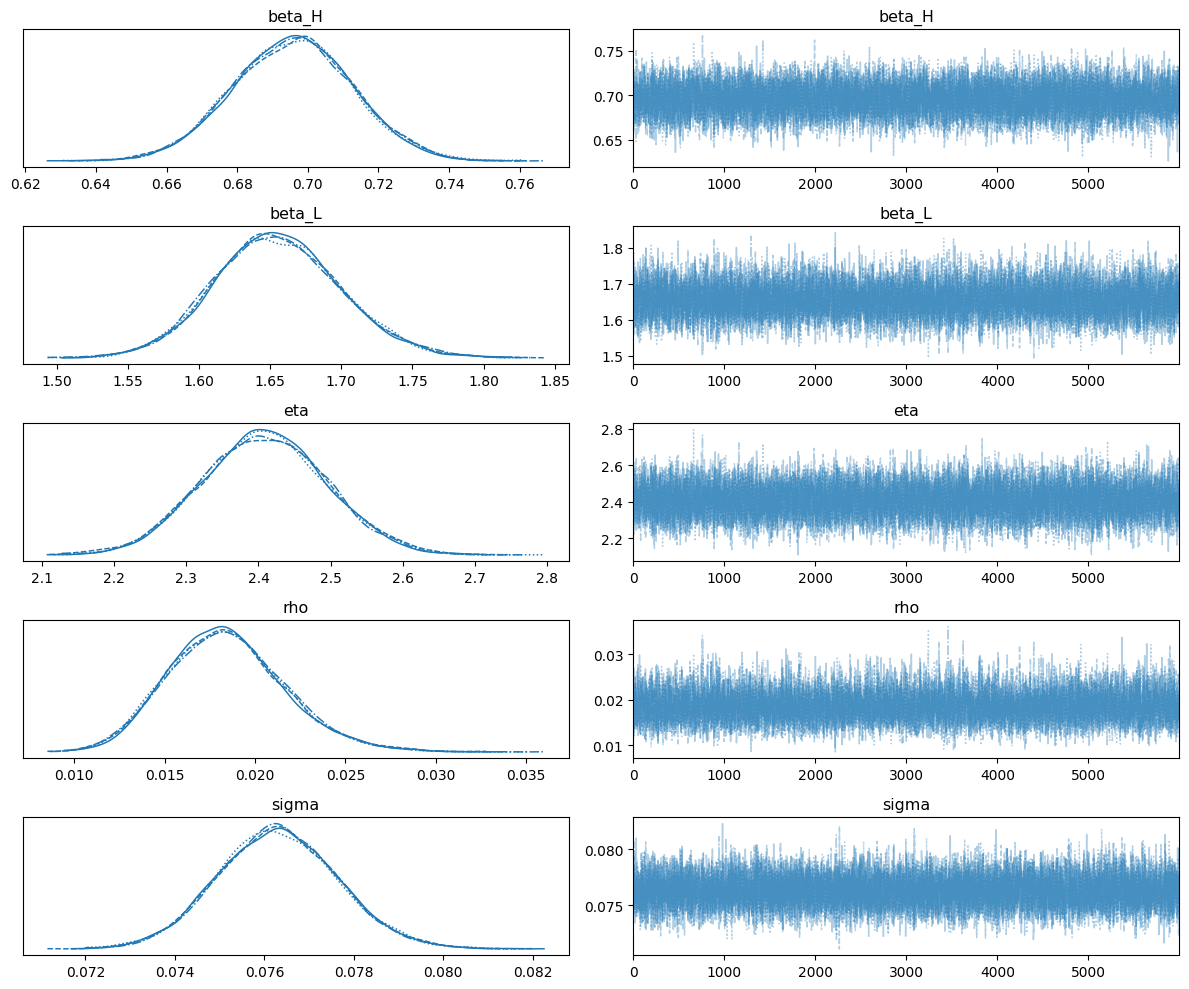

In [52]:
az.plot_trace(idata)
plt.tight_layout()

In [53]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[2.32179188 2.40753963 2.49414419]
[0.01520795 0.01825806 0.02159633]
[1.6120761  1.65417569 1.69928061]
[0.67884572 0.69595906 0.71233737]


In [54]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_H,0.696,0.017,0.664,0.728,0.000,0.000,11535.396,13155.915,1.0
beta_L,1.656,0.044,1.574,1.742,0.000,0.000,10072.686,11161.079,1.0
eta,2.408,0.086,2.250,2.573,0.001,0.001,11072.230,13202.197,1.0
rho,0.018,0.003,0.013,0.025,0.000,0.000,9501.764,10756.544,1.0
sigma,0.076,0.001,0.074,0.079,0.000,0.000,16696.110,15677.187,1.0


In [55]:
posterior_eta.values.flatten()

array([2.40523968, 2.29283926, 2.41417852, ..., 2.36210296, 2.37474295,
       2.39379076])

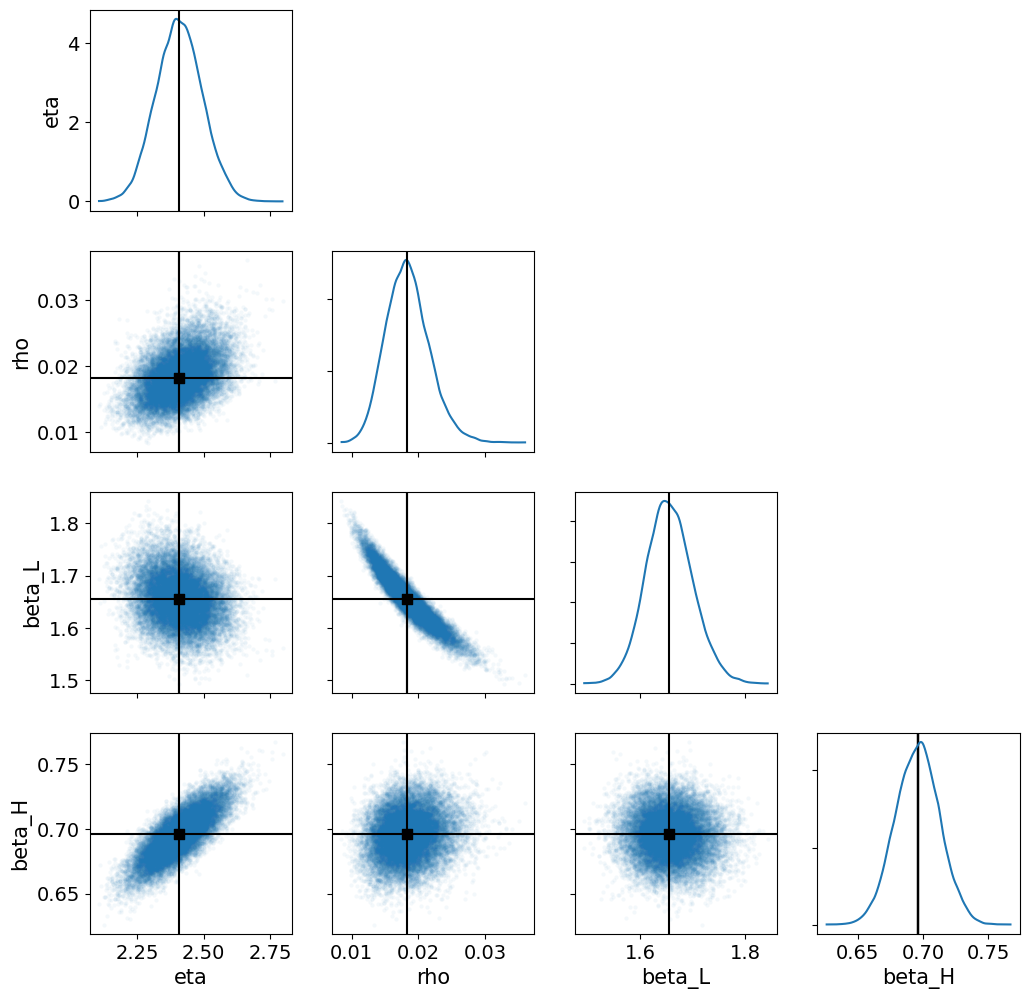

In [56]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [57]:
# loss  mean
eta_mean = np.mean(idata["posterior"]["eta"].values)
rho_mean = np.mean(idata["posterior"]["rho"].values)
beta_L_mean = np.mean(idata["posterior"]["beta_L"].values)
beta_H_mean = np.mean(idata["posterior"]["beta_H"].values)

phi = eta_mean * (rho_mean * n_LF**(-beta_L_mean) + n_HF**(-beta_H_mean))
loss = np.mean((phi - rel_error)**2)

In [58]:
loss

0.21992201895922694

In [59]:
# loss  median
eta_median = .124
rho_median = 5.539
beta_L_median = .630
beta_H_median = 2.176

phi = eta_median * (rho_median * n_LF**(-beta_L_median) + n_HF**(-beta_H_median))
loss = np.mean((phi - rel_error)**2)

In [60]:
loss

0.014337139068885582

In [61]:
type(idata["posterior"]["eta"])

xarray.core.dataarray.DataArray

In [62]:
# define the error function
def error_function(n_LF, n_HF):
    eta = 0.55464788
    rho = 2.42445591
    beta_L = 0.71932452
    beta_H = 1.40160385
    return eta * (rho * n_LF**(-beta_L) + n_HF**(-beta_H))


In [63]:
error_function(60, 9)

0.09622394048841161